In [1]:
import os
import torch as th
import numpy as np
import json 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import motornet as mn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
import math

In [2]:
from dynamics_analysis import *
from environment import *
from networks import *
from neural_activity import *
from utils import *
from training import *

In [3]:
# Create your effector (for instance, using RigidTendonArm26 with MujocoHillMuscle)
arm26 = mn.effector.RigidTendonArm26(muscle=mn.muscle.MujocoHillMuscle())
arm210 = Arm('arm210').effector

# Instantiate the custom reach environment.
#env = create_defaultReachTask(arm)
#env = CustomReachEnv(effector=arm)
env26 = CustomTargetReach(
effector=arm26,
obs_noise=0.0,
proprioception_noise=0.0,
vision_noise=0.0,
action_noise=0.0
)

env210 = CustomTargetReach(
effector=arm210,
obs_noise=0.0,
proprioception_noise=0.0,
vision_noise=0.0,
action_noise=0.0
)


In [ ]:
def pretrain(env, device='cpu', n_batch=400, batch_size=4, pretrained_policy=None, model_name=None, ppo_kwargs=None):
    """
    Pretrain the custom Actor-Critic network on a reach task
    
    The training follows MotorNet's tutorial:
        - At the beginning of each batch, the hidden state is initialized.
        - The environment is reset with a batch_size
        - A full episode is simulated: at each step, the policy produces an action,
        which is passed to the env.step() method. The fingertip positions (xy) and
        target positions (tg) are stored.
    
    Returns:
        policy: the trained ACNetwork object.
        losses: a list of loss values (one per batch).
    """

    ### Setup ###
    device = th.device(device)
    print(f'Device: {device}')

    # PPO Hyperparams
    default_ppo = {
        'gamma': 0.99,
        'clip_epsilon': 0.2,
        'update_epochs': 20,
        'learning_rate': 3e-4,
        'optimizer_lr': 1e-3,
        'grad_norm_clip': 0.5,  # Added gradient clipping hyperparameter
        'neural_reg_weight': 0.01,  # Neural activity regularization
        'derivative_reg_weight': 0.1,  # Derivative regularization
        }
    if ppo_kwargs is not None:
        merged_ppo = default_ppo.copy()
        merged_ppo.update(ppo_kwargs)
        ppo_kwargs = merged_ppo
    else:
        ppo_kwargs = default_ppo.copy()

    # Extract hyperparameters
    gamma = ppo_kwargs['gamma']
    clip_epsilon = ppo_kwargs['clip_epsilon']
    update_epochs = ppo_kwargs['update_epochs']
    learning_rate = ppo_kwargs['learning_rate']
    optimizer_lr = ppo_kwargs['optimizer_lr']
    grad_norm_clip = ppo_kwargs['grad_norm_clip']
    neural_reg_weight = ppo_kwargs['neural_reg_weight']
    derivative_reg_weight = ppo_kwargs['derivative_reg_weight']

    lr_schedule = lambda epoch: learning_rate

    # Instantiate the custom ACNetwork using environment properties.
    if pretrained_policy is None:
        policy = ACNetwork(env.observation_space, env.action_space, lr_schedule, device, name=model_name)
    else:
        policy = pretrained_policy.to(device)
    policy.train()  # set to training mode

    optimizer = th.optim.Adam(policy.parameters(), lr=optimizer_lr)
    losses = []
    interval = 250  # Logging interval

    # Initial exploration parameters
    initial_sigma = math.sqrt(0.1 / (1 + math.exp(5)))  # ~0.0259
    policy.actor.sigma = initial_sigma
    print(f"Initial exploration sigma: {initial_sigma:.4f}")

    # Rollout
    for batch in range(n_batch):

        # Initialize hidden state (for GRU) for current batch.
        h = policy.actor.init_hidden(batch_size=batch_size)
        obs, info = env.reset(options={"batch_size": batch_size}) 
        obs = th.as_tensor(obs, device=device, dtype=th.float32)  # Convert numpy to tensor on device
        terminated = th.zeros(batch_size, dtype=th.bool, device=obs.device)
        rewards_list = []
        hidden_states_list = []  # Track hidden states for regularization
        # Record initial fingertip positions and target positions.
        xy_list = [info["states"]["fingertip"][:, None, :]]
        tg_list = [info["goal"][:, None, :]]
        trajectory_data = {
                'obs': [], 'actions': [], 'logp': [], 'values': []
            }
        
        # Simulate full episode until termination.
        while not terminated.all():

            if not isinstance(obs, th.Tensor):
                obs = th.as_tensor(obs, device=device, dtype=th.float32)  

            with th.no_grad():
                action, value, logp, new_hidden = policy(obs, deterministic=False)

            hidden_states_list.append(new_hidden)
            trajectory_data['obs'].append(obs)
            trajectory_data['actions'].append(action)
            trajectory_data['logp'].append(logp)
            trajectory_data['values'].append(value)

            # Convert action to CPU before environment step
            action_cpu = action.detach().cpu()

            #Step in environment
            obs, reward, terminated, truncated, info = env.step(action=action_cpu)

            # Convert environment outputs to device
            obs = th.as_tensor(obs, device=device, dtype=th.float32)
            reward = th.as_tensor(reward, device=device, dtype=th.float32)
            terminated = th.as_tensor(terminated, device=device)
            
            rewards_list.append(reward)
            # Record current fingertip position and target.
            xy_list.append(info["states"]["fingertip"][:, None, :])
            tg_list.append(info["goal"][:, None, :])

        
        # --- Exploration Annealing Update ---
        # Calculate mean return for this batch
        rewards_tensor = th.cat(rewards_list, dim=0)  # (T, batch_size, 1)
        batch_returns = th.sum(rewards_tensor, dim=0)  # (batch_size, 1)
        mean_return = batch_returns.mean().item()
        
        # Update return buffer and calculate r_hat
        policy.return_buffer.append(mean_return)
        r_hat = np.mean(policy.return_buffer) if policy.return_buffer else 0.0

        # Concatenate the list over timesteps.
        xy = th.cat(xy_list, axis=1)
        tg = th.cat(tg_list, axis=1)

        # Update exploration noise
        #?#denominator = 1 + math.exp(5 + 15 * r_hat)
        new_sigma = 0.05 #?#math.sqrt(0.1 / denominator)
        policy.actor.sigma = new_sigma

        # Prepare trajectory tensors
        obs_tensor = th.stack(trajectory_data['obs'])
        actions_tensor = th.stack(trajectory_data['actions'])
        logp_old_tensor = th.stack(trajectory_data['logp']).flatten()
        values_tensor = th.stack(trajectory_data['values'])
        rewards_tensor = th.stack(rewards_list)

        # Calculate advantages and returns
        T = rewards_tensor.shape[0]
        returns = th.zeros_like(rewards_tensor)
        future_return = th.zeros((batch_size, 1), device=device)
        for t in reversed(range(T)):
            future_return = rewards_tensor[t] + ppo_kwargs['gamma'] * future_return
            returns[t] = future_return
        advantages = returns - values_tensor

        # Regularization calculations
        hidden_states = th.stack(hidden_states_list)
        neural_reg = ppo_kwargs['neural_reg_weight'] * th.mean(hidden_states**2)
        if hidden_states.shape[0] > 1:
            derivatives = hidden_states[1:] - hidden_states[:-1]
            deriv_reg = ppo_kwargs['derivative_reg_weight'] * th.mean(derivatives**2)
        else:
            deriv_reg = 0.0
        
        # Perform PPO updates over several epochs.
        ppo_loss = 0.0
        value_loss = 0.0
        total_epoch_loss = 0
        for epoch in range(update_epochs):

            # Re-evaluate actions on the entire rollout:
            new_values, new_logp, entropy = policy.evaluate_actions(obs_tensor.flatten(0, 1), actions_tensor.flatten(0, 1), None)
            
            # Policy loss
            ratio = th.exp(new_logp - logp_old_tensor)
            advantages_flat = advantages.flatten()
            surr1 = ratio * advantages_flat
            surr2 = th.clamp(ratio, 1-ppo_kwargs['clip_epsilon'], 
                            1+ppo_kwargs['clip_epsilon']) * advantages_flat
            policy_loss = -th.mean(th.min(surr1, surr2))
            
            # Value loss
            value_loss = F.mse_loss(new_values.view(-1), returns.view(-1))
            
            # Total loss with regularization
            total_loss = (policy_loss + value_loss + neural_reg + deriv_reg)
            
            # Optimize
            optimizer.zero_grad()
            total_loss.backward()
            th.nn.utils.clip_grad_norm_(
                policy.parameters(),
                ppo_kwargs['grad_norm_clip']
            )
            optimizer.step()
            
            total_epoch_loss += total_loss.item()

        # Logging
        avg_loss = total_epoch_loss / ppo_kwargs['update_epochs']
        losses.append(avg_loss)
        if batch % 50 == 0:
            print(
                f"Batch {batch:04d}/{n_batch} | "
                f"R̂: {r_hat:.2f} | "
                f"σ: {new_sigma:.4f} | "
                f"Loss: {avg_loss:.2f} | "
                f"Neural Reg: {neural_reg.item():.2e} | "
                f"Deriv Reg: {deriv_reg.item():.2e}"
            )
    
    plot_loss(losses)  # Plotting
    try:

        # Final operations
        save_model(policy, losses, env)  # Save model

    except:
        save_model(policy, losses, env)
        return policy, losses
    
    #evaluate_pretrained(policy, env, batch_size)  # Evaluation

    return policy, losses

In [5]:
DEVICE = 'cuda:0' if th.cuda.is_available() else 'cpu'

Device: cuda:0
Initial exploration sigma: 0.0259
Batch 0000/500 | R̂: -79364.17 | σ: 0.2000 | Loss: 30599.44 | Neural Reg: 2.09e-04 | Deriv Reg: 2.43e-06
Batch 0050/500 | R̂: -75845.31 | σ: 0.2000 | Loss: 13558.47 | Neural Reg: 8.55e-03 | Deriv Reg: 2.83e-07
Batch 0100/500 | R̂: -76956.99 | σ: 0.2000 | Loss: 6981.48 | Neural Reg: 8.51e-03 | Deriv Reg: 3.60e-07
Batch 0150/500 | R̂: -76312.68 | σ: 0.2000 | Loss: 5284.62 | Neural Reg: 9.24e-03 | Deriv Reg: 1.50e-07
Batch 0200/500 | R̂: -76979.50 | σ: 0.2000 | Loss: 4411.91 | Neural Reg: 9.23e-03 | Deriv Reg: 1.69e-07
Batch 0250/500 | R̂: -76451.10 | σ: 0.2000 | Loss: 3542.29 | Neural Reg: 9.23e-03 | Deriv Reg: 1.71e-07
Batch 0300/500 | R̂: -76251.14 | σ: 0.2000 | Loss: 3284.25 | Neural Reg: 9.30e-03 | Deriv Reg: 1.39e-07
Batch 0350/500 | R̂: -76585.23 | σ: 0.2000 | Loss: 3411.51 | Neural Reg: 9.51e-03 | Deriv Reg: 8.76e-08
Batch 0400/500 | R̂: -75737.01 | σ: 0.2000 | Loss: 3361.51 | Neural Reg: 9.50e-03 | Deriv Reg: 8.96e-08
Batch 0450/50

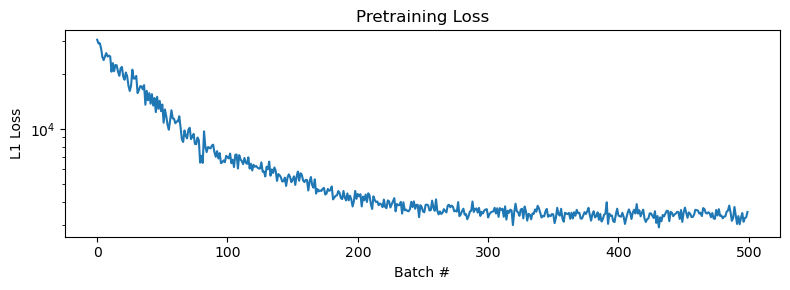

Done saving model's weights, training history and env in ../outputs\savedmodels\2025-04-22\Default26_clipped_7


In [ ]:
ppo = {
        'gamma': 0.99,
        'clip_epsilon': 0.2,
        'update_epochs': 20,
        'learning_rate': 3e-4,
        'optimizer_lr': 1e-3,
        'grad_norm_clip': 1.0,  # Added gradient clipping hyperparameter
        'neural_reg_weight': 0.01,  # Neural activity regularization
        'derivative_reg_weight': 0.1,  # Derivative regularization
        }
policy26, training_losses = pretrain(env26, device=DEVICE, n_batch=500, batch_size=128, pretrained_policy=None, model_name='Default26_clipped_10', ppo_kwargs=ppo)

In [11]:
policy26 = load_model(env26, ACNetwork, '../outputs/savedmodels/2025-04-22/Default26_L1_reward2/weights')

Device: cuda:0
Initial exploration sigma: 0.0259
Batch 0000/500 | R̂: -82955.73 | σ: 0.2000 | Loss: 38758.83 | Neural Reg: 6.99e-04 | Deriv Reg: 4.95e-06
Batch 0050/500 | R̂: -82477.57 | σ: 0.2000 | Loss: 19086.93 | Neural Reg: 1.32e-03 | Deriv Reg: 2.83e-06
Batch 0100/500 | R̂: -84529.60 | σ: 0.2000 | Loss: 11624.88 | Neural Reg: 9.00e-03 | Deriv Reg: 4.97e-07
Batch 0150/500 | R̂: -84749.35 | σ: 0.2000 | Loss: 9119.82 | Neural Reg: 9.59e-03 | Deriv Reg: 1.56e-07
Batch 0200/500 | R̂: -83821.82 | σ: 0.2000 | Loss: 7179.48 | Neural Reg: 9.64e-03 | Deriv Reg: 1.09e-07
Batch 0250/500 | R̂: -84728.67 | σ: 0.2000 | Loss: 5853.82 | Neural Reg: 9.68e-03 | Deriv Reg: 1.00e-07
Batch 0300/500 | R̂: -84808.79 | σ: 0.2000 | Loss: 6110.71 | Neural Reg: 9.69e-03 | Deriv Reg: 9.49e-08
Batch 0350/500 | R̂: -83985.81 | σ: 0.2000 | Loss: 5359.08 | Neural Reg: 9.71e-03 | Deriv Reg: 7.77e-08
Batch 0400/500 | R̂: -83715.21 | σ: 0.2000 | Loss: 4281.81 | Neural Reg: 9.69e-03 | Deriv Reg: 8.33e-08
Batch 0450/5

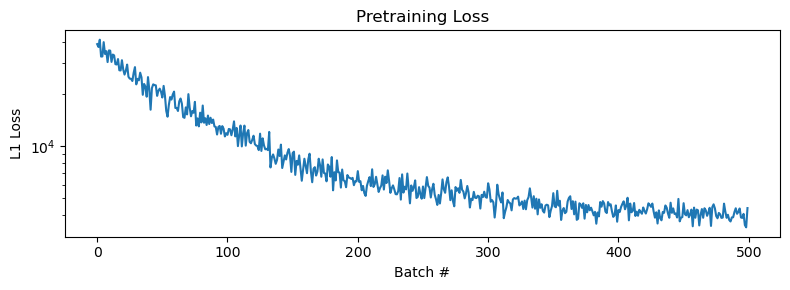

Done saving model's weights, training history and env in ../outputs\savedmodels\2025-04-22\Default210_clipped_9_eps_3


In [12]:
ppo = {
        'gamma': 0.99,
        'clip_epsilon': 0.3,
        'update_epochs': 20,
        'learning_rate': 3e-4,
        'optimizer_lr': 1e-3,
        'grad_norm_clip': 0.9,  # Added gradient clipping hyperparameter
        'neural_reg_weight': 0.01,  # Neural activity regularization
        'derivative_reg_weight': 0.1,  # Derivative regularization
        }
policy210, training_losses = pretrain(env210, device=DEVICE, n_batch=500, batch_size=128, pretrained_policy=None, model_name='Default210_clipped_9_eps_3', ppo_kwargs=None)

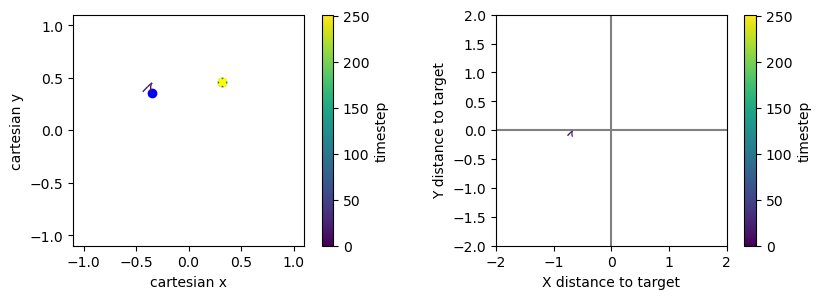

In [107]:
policy210 = load_model(env210, ACNetwork, '../outputs/savedmodels/2025-04-22/Default210_clipped_9_eps_3/weights')
evaluate_pretrained(policy210, env210, 1)